In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
df = pd.read_csv('Ventas.csv', parse_dates=['Fecha'], dayfirst=False)

df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d', errors='coerce')

# Now you can access the parsed dates
print(df.head())

train_size = int(len(df) * 0.7)
train_df = df[0:train_size]
test_df = df[train_size:len(df)]

       Fecha  Gas licuado de petróleo  Gasolina regular  Gasolina superior  \
0 2000-01-01            194410.476190         202645.20          308156.82   
1 2000-02-01            174710.552381         205530.96          307766.31   
2 2000-03-01            189234.066667         229499.56          331910.29   
3 2000-04-01            174330.607143         210680.40          315648.08   
4 2000-05-01            191745.147619         208164.34          319667.97   

      Diesel  
0  634667.06  
1  642380.66  
2  699807.25  
3  586803.98  
4  656948.20  


In [8]:
Gasr_df = train_df['Gasolina regular']
Gasr_df.head(10)

0    202645.20
1    205530.96
2    229499.56
3    210680.40
4    208164.34
5    195088.74
6    204556.77
7    218388.51
8    213906.96
9    213606.65
Name: Gasolina regular, dtype: float64

In [9]:
Gass_df = train_df['Gasolina superior']
Gass_df.head(10)

0    308156.82
1    307766.31
2    331910.29
3    315648.08
4    319667.97
5    300347.70
6    308305.93
7    323011.86
8    326455.72
9    323843.63
Name: Gasolina superior, dtype: float64

# ARIMA Gasolina Regular #

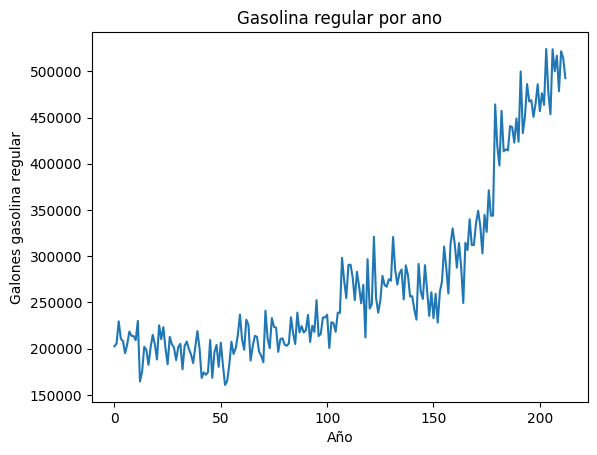

In [10]:
plt.plot(Gasr_df)
plt.gca().set(title="Gasolina regular por ano", xlabel="Año", ylabel="Galones gasolina regular")
plt.show()

# ARIMA Gasolina super #

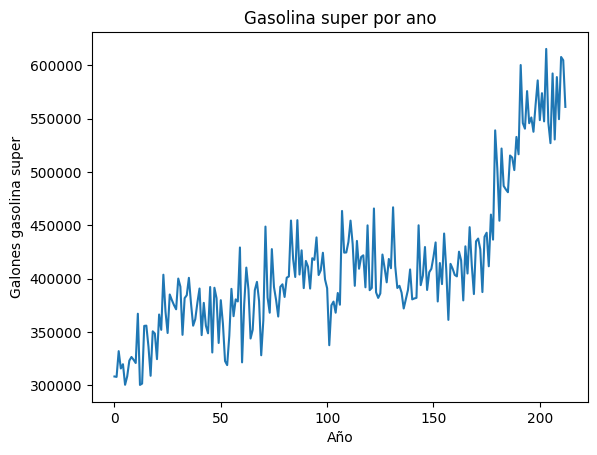

In [11]:
plt.plot(Gass_df)
plt.gca().set(title="Gasolina super por ano", xlabel="Año", ylabel="Galones gasolina super")
plt.show()